In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback,set_config

In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset and Dataloader

In [3]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [4]:
bs= 16
crop_size= 28

train_transform= transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(32),
    transforms.RandomResizedCrop(crop_size,scale=(0.7,1.0)),
    
    transforms.ToTensor()
])
test_transform =transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()
]) 

# data test gak perlu kita augmentasi karna data test ini yang menjadi acuan data train kita dalam menghitung loss untuk melakukan prediksi
# data test hanya di ubah ukuran nya sesuai ukuran data train agar jumlah feature atau pixel nya sama (hanya dilakukan resize lalu center crop)


train_set= datasets.ImageFolder("dataset_aksara_jawa/train/",transform=train_transform)
trainloader= DataLoader(train_set,batch_size=bs, shuffle=True, num_workers=2)

test_set=datasets.ImageFolder("dataset_aksara_jawa/test/",transform=test_transform)
testloader= DataLoader(test_set, batch_size=bs, shuffle= True)

* data test jangan di augmentasi, karna jika di augmentasi maka kita akan merubah target prediksi kita. data test hanya dirubah atau disamakan ukuran gambar nya dengan ukuran data train, sebelum di crop maka data test harus di resize dulu, supaya kalau ada data yang ukuran nya gak wajar, kita tetap bisa mengambil informasi penting nya. setelah di resize, baru deh center crop sebesar ukuran data train kita
* gak semua data bisa kita lakukan data augmentasi, karna kalau data sudah kita augmentasi tapi setelah itu merubah makna, maka data itu jadi tidak valid. contoh data yang yang gak boleh kita kasih augmentasi flip horizontal adalah data gambar paru paru ( kalau di flip maka paru paru nya jadi di kiri dong) jadi inti nya gak semua data harus kita kasih teknik augmentasi, harus pahami dulu kegunaan data nya. augmentasi depand terhadap kasus nya

In [5]:
feature,target= next(iter(trainloader))
feature.shape

torch.Size([16, 3, 28, 28])

In [6]:
label2cat= train_set.classes
label2cat

['ba',
 'ca',
 'da',
 'dha',
 'ga',
 'ha',
 'ja',
 'ka',
 'la',
 'ma',
 'na',
 'nga',
 'nya',
 'pa',
 'ra',
 'sa',
 'ta',
 'tha',
 'wa',
 'ya']

# Arsitektur and Config

data kita udah di crop menjadi 64x64 dengan warna rgb atau 3 channel, oleh karena itu misal nya kita ingin concatenate hasil filter kita menjadi 8 lalu 16,32 (bebas mau make berapa jumlah filter, yang mana ini akan menentukan jumlah channel kita berikut nya) lalu untuk pooling ini misal n

In [7]:
class CNN (nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1,1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 2, 1,1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1,1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        self.fc= nn.Sequential(
            nn.Linear(1152,1000),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1000,20),
            nn.LogSoftmax(1)
            
        
        )
        
    def forward(self,x):
        x= self.cnn(x)
        x= self.fc(x)
        return x

masuk dalam tahapan config, apa aja yang mau kita save,contoh nya input size dkk, tapi karna arsitektur kita udah ditentuin dari awal maka gak perlu kayak nya,mungkin batch size sama crop size aja

In [8]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation ~> MCOC

In [9]:
model=CNN().to(device)

In [10]:
criterion=nn.NLLLoss()

In [11]:
optimizer=optim.AdamW(model.parameters(),lr= 0.0005)

In [12]:
callback=Callback(model, config,outdir="model_10")

# Training Loop (feedforward, hitung cost, backprop, update weight)

In [13]:
from tqdm.auto import tqdm

In [14]:
def loop_fn(mode, dataset, dataloader, model, creterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost=correct=0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature,target= feature.to(device),target.to(device)
        output= model(feature)
        loss= criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost+=loss.item()*feature.shape[0]
        correct+=(output.argmax(1) == target).sum().item()
    cost= cost/len(dataset)
    acc= correct/len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 3.0013 | Test_cost  = 2.9959 | Train_score = 0.0373 | Test_score = 0.0510 |




Epoch     2
Train_cost  = 2.9978 | Test_cost  = 2.9960 | Train_score = 0.0366 | Test_score = 0.0471 |
==> EarlyStop patience =  1 | Best test_score: 0.0510




Epoch     3
Train_cost  = 2.9979 | Test_cost  = 2.9963 | Train_score = 0.0434 | Test_score = 0.0471 |
==> EarlyStop patience =  2 | Best test_score: 0.0510




Epoch     4
Train_cost  = 2.9982 | Test_cost  = 2.9957 | Train_score = 0.0412 | Test_score = 0.0510 |
==> EarlyStop patience =  3 | Best test_score: 0.0510




Epoch     5
Train_cost  = 2.9973 | Test_cost  = 2.9959 | Train_score = 0.0419 | Test_score = 0.0471 |
==> EarlyStop patience =  4 | Best test_score: 0.0510




Epoch     6
Train_cost  = 2.9976 | Test_cost  = 2.9958 | Train_score = 0.0389 | Test_score = 0.0510 |
==> EarlyStop patience =  5 | Best test_score: 0.0510
==> Execute Early Stopping at epoch: 6 | Best test_score: 0.0510
==> Best model is saved at model_10


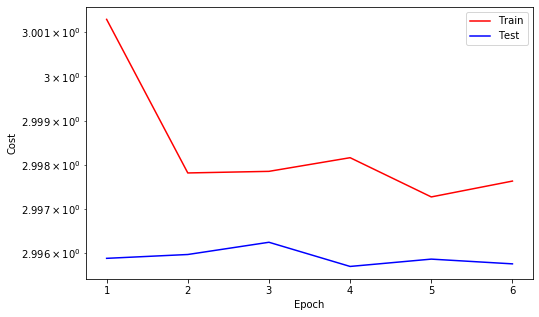

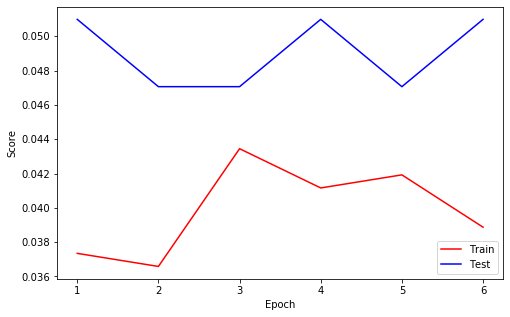

In [15]:
while True:
    train_cost, train_score = loop_fn("train",train_set,trainloader,model,criterion,optimizer,device) 
    with torch.no_grad():
        test_cost,test_score= loop_fn("test",test_set,testloader,model,criterion,optimizer,device) 
        
    callback.log(train_cost,test_cost,train_score,test_score)
    
    callback.save_checkpoint()
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [16]:
import matplotlib.pyplot as plt

In [17]:
feature,target= next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    pred = output.argmax(1)
pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

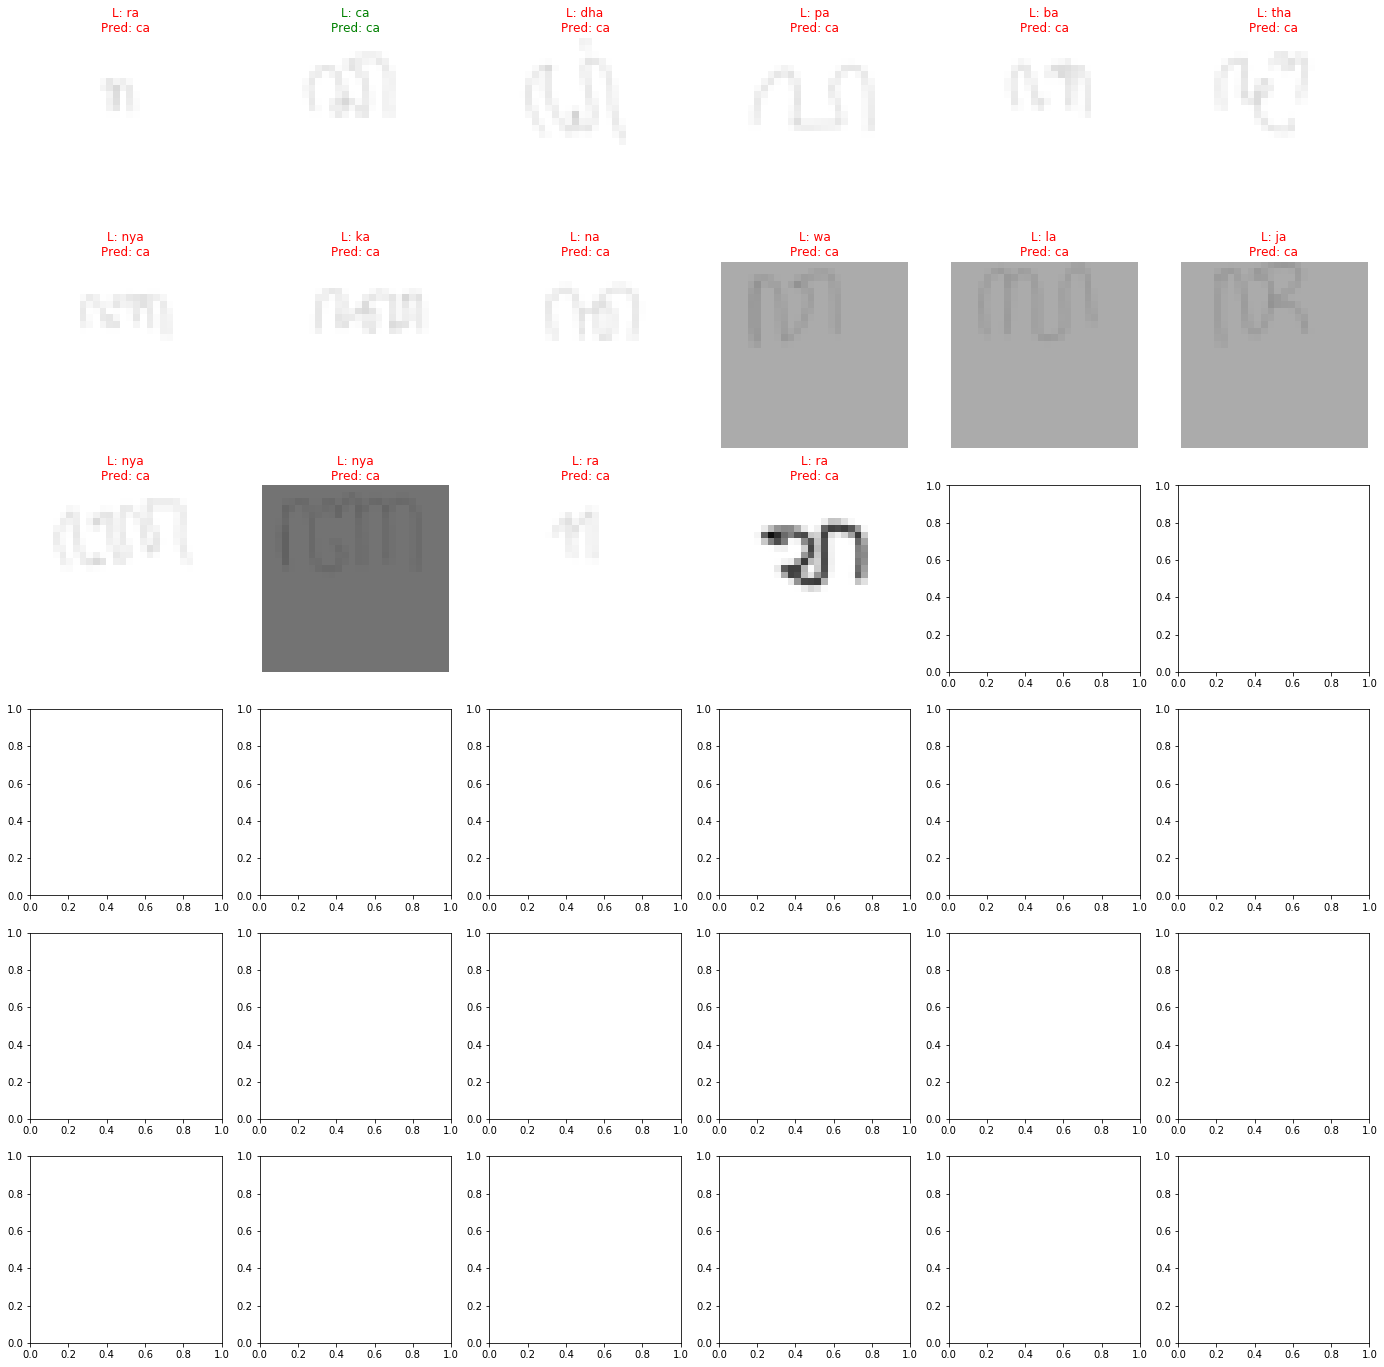

In [19]:
fig, axes= plt.subplots(6, 6, figsize= (24, 24))
for img, label,pred, ax in zip(feature, target, pred,axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":"r"} if label !=pred else {"color" :"g"}
    label,pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label}\nPred: {pred}",fontdict=font);
    ax.axis("off");